In [19]:
import warnings  # python运行代码的时候，经常会碰到代码可以正常运行但是会提出警告，不想看到这些不重要的警告，所以使用控制警告输出

warnings.filterwarnings("ignore")  # 使用警告过滤器来控制忽略发出的警告

import pandas as pd
import numpy as np
import matplotlib  # python中类似于MATLAB的绘图工具，是一个2D绘图库
import matplotlib.pyplot as plt
import datetime  # datetime模块提供了各种类,用于操作日期和时间

%matplotlib inline
#%matplotlib inline 表示内嵌绘图，有了这个命令就可以省略掉plt.show()命令了
from finrl.config import config  # 引入finrl包的配置
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.env_stocktrading import StockTradingEnv
from finrl.model.models import DRLAgent, DRLEnsembleAgent

from finrl.trade.backtest import (
    backtest_stats,
    get_daily_return,
    get_baseline,
    backtest_plot,
)
from pprint import pprint  # 用于打印 Python 数据结构. 使输出数据格式整齐, 便于阅读

import sys  # 该语句告诉Python，我们想要使用sys，此模块包含了与Python解释器和它的环境有关的函数

sys.path.append("../FinRL-Library")
# 在Python执行import sys语句的时候，python会根据sys.path的路径来寻找sys.py模块。
# 添加自己的模块路径， Sys.path.append(“mine module path”)

import itertools  # itertools模块中的函数可以用来对数据进行循环操作

In [7]:
import os

if not os.path.exists("./" + config.DATA_SAVE_DIR):  # "./"代表当前目录
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [8]:
config.START_DATE
config.END_DATE
print(config.SSE_choose30_TICKER)

# 缓存数据，如果日期或者股票列表发生变化，需要删除该缓存文件重新下载
SAVE_PATH = "./datasets/China_SSE_20210101-12h19.csv"
if os.path.exists(SAVE_PATH):
    df = pd.read_csv(SAVE_PATH)
else:
    df = YahooDownloader(
        config.START_DATE,  #'2000-01-01',
        config.END_DATE,  # 2021-01-01，预计将改日期改为'2021-06-20'（今日日期）
        ticker_list=config.SSE_choose30_TICKER,
    ).fetch_data()  # SSE_choose30_TICKER上证选择30只股票
    df.to_csv(SAVE_PATH)

['600000.SS', '600104.SS', '600030.SS', '601628.SS', '601166.SS', '601318.SS', '601328.SS', '601088.SS', '601857.SS', '601601.SS', '601668.SS', '601288.SS', '601818.SS', '601989.SS', '601398.SS', '600048.SS', '600028.SS', '600050.SS', '600519.SS', '600016.SS', '600887.SS', '601688.SS', '601186.SS', '601988.SS', '601211.SS', '601336.SS', '600309.SS', '603160.SS', '600690.SS', '600276.SS']


In [9]:
df.head()  # 最开始5条
df.tail()  # tail仅展示了最后五条数据
df.shape
df.sort_values(["date", "tic"]).head()  # ticker表示股票代码，e.g.AAPL是苹果的股票
tech_indicators = ["macd", "rsi_30", "cci_30", "dx_30"]

fe = FeatureEngineer(
    use_technical_indicator=True,
    tech_indicator_list=tech_indicators,
    use_turbulence=True,
    user_defined_feature=False,
)
SAVE_PATH = "./datasets/_China_SSE_20210101-12h19.preprocess.csv"
if os.path.exists(SAVE_PATH):
    processed = pd.read_csv(SAVE_PATH)
else:
    processed = fe.preprocess_data(df)
    processed.to_csv(SAVE_PATH)

list_ticker = processed["tic"].unique().tolist()  # 按照processed的"tic"列去重
list_date = list(
    pd.date_range(processed["date"].min(), processed["date"].max()).astype(str)
)  # 成一个固定频率的时间索引
combination = list(itertools.product(list_date, list_ticker))

processed_full = pd.DataFrame(combination, columns=["date", "tic"]).merge(
    processed, on=["date", "tic"], how="left"
)

processed_full = processed_full[processed_full["date"].isin(processed["date"])]
# isin函数，清洗数据，删选过滤掉processed_full中一些行，processed_full新加一列['date']若和processed_full中的['date']不相符合，则被剔除
processed_full = processed_full.sort_values(["date", "tic"])

processed_full = processed_full.fillna(0)
# 对于processed_full数据集中的缺失值使用 0 来填充.
processed_full.sample(5)

,date,tic,Unnamed: 0,open,high,low,close,volume,day,macd,rsi_30,cci_30,dx_30,turbulence
148358,2013-07-19,600519.SS,53498.0,152.900833,152.900833,144.239670,127.630417,8871625.0,4.0,-1.298530,41.967450,-248.688811,45.765457,50.984526
68281,2006-03-29,600104.SS,13431.0,2.707692,2.746153,2.692307,1.507882,10117923.0,2.0,-0.000016,50.320982,-45.817682,8.833507,36.682977
92795,2008-06-23,600016.SS,22252.0,3.350694,3.460648,3.292824,2.204849,78195158.0,0.0,-0.192308,35.866548,-118.343302,56.161169,20.278361
188165,2017-03-07,600016.SS,78481.0,7.458333,7.483333,7.441666,6.050364,41207872.0,1.0,-0.033307,42.199236,-158.064362,28.730959,14.531520
36236,2003-04-25,601818.SS,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


In [10]:
stock_dimension = len(processed_full.tic.unique())
state_space = 1 + 2*stock_dimension + len(tech_indicators)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": tech_indicators,
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "print_verbosity":5
    
}

rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)
train_start = '2009-01-01'
train_end = '2015-10-01'
val_test_start = '2015-10-01'
val_test_end = '2020-07-20'

ensemble_agent = DRLEnsembleAgent(df=processed_full,
                 train_period=(train_start,train_end),
                 val_test_period=(val_test_start,val_test_end),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window, 
                 **env_kwargs)

A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.01,
                    'learning_rate': 0.0005
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      "action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 50_000,
                      "learning_rate": 0.000005,
                      "batch_size": 128
                    }

timesteps_dict = {'a2c' : 30_000, 
                 'ppo' : 100_000, 
                 'ddpg' : 10_000
                 }


timesteps_dict = {'a2c' : 1_000, 
                 'ppo' : 1_000, 
                 'ddpg' : 1_000
                 }

df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)


Stock Dimension: 30, State Space: 181
============Start Ensemble Strategy============
nan
turbulence_threshold:  1074.3215580866
======Model training from:  2009-01-01 to  2015-10-08
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0005}
Using cuda device
Logging to tensorboard_log/a2c/a2c_126_9
-------------------------------------
| time/                 |           |
|    fps                | 87        |
|    iterations         | 100       |
|    time_elapsed       | 5         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -42.7     |
|    explained_variance | -1.19e-07 |
|    n_updates          | 99        |
|    policy_loss        | -32.8     |
|    std                | 1.01      |
|    value_loss         | 0.794     |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 87       |
|    iterations         | 200 

In [11]:
df_summary

(    Iter   Val Start     Val End Model Used A2C Sharpe PPO Sharpe DDPG Sharpe
 0    126  2015-10-08  2016-01-06       DDPG  -0.058994  -0.045342   -0.015606
 1    189  2016-01-06  2016-04-12       DDPG   0.061627   0.121967    0.295176
 2    252  2016-04-12  2016-07-13        A2C   0.396834   0.367212    0.101819
 3    315  2016-07-13  2016-10-19       DDPG   0.042266  -0.058827    0.100872
 4    378  2016-10-19  2017-01-17        PPO  -0.107542   0.212057   -0.097697
 5    441  2017-01-17  2017-04-25        PPO  -0.168318   0.162224   -0.079165
 6    504  2017-04-25  2017-07-26        PPO   0.290353   0.357564    0.069529
 7    567  2017-07-26  2017-10-30        PPO   0.239564   0.418094    0.295123
 8    630  2017-10-30  2018-01-26        PPO   0.170852   0.227188   -0.187728
 9    693  2018-01-26  2018-05-08       DDPG   0.001645  -0.120631    0.100739
 10   756  2018-05-08  2018-08-06        PPO  -0.224311  -0.186269   -0.203568
 11   819  2018-08-06  2018-11-09       DDPG  -0.136

In [12]:
unique_trade_date = processed_full[(processed_full.date > val_test_start)&(processed_full.date <= val_test_end)].date.unique()

In [13]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = df_account_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  0.8709027707792414


In [14]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,1000000.000000,2016-01-06,NaN,2016-01-06
1,997697.707134,2016-01-07,-0.002302,2016-01-07
2,999038.588988,2016-01-08,0.001344,2016-01-08
3,994711.253494,2016-01-11,-0.004331,2016-01-11
4,994151.188943,2016-01-12,-0.000563,2016-01-12


<AxesSubplot:>

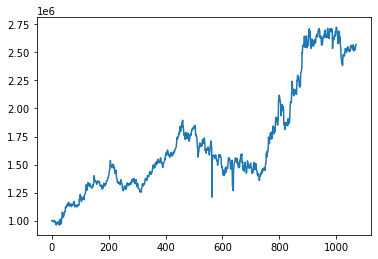

In [15]:
%matplotlib inline
df_account_value.account_value.plot()

In [16]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return          0.248746
Cumulative returns     1.570485
Annual volatility      0.311465
Sharpe ratio           0.870903
Calmar ratio           0.687258
Stability              0.797886
Max drawdown          -0.361940
Omega ratio            1.214469
Sortino ratio          1.310253
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.180263
Daily value at risk   -0.038164
dtype: float64


In [17]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1109, 8)
Annual return          0.100252
Cumulative returns     0.522647
Annual volatility      0.201535
Sharpe ratio           0.575973
Calmar ratio           0.270323
Stability              0.777048
Max drawdown          -0.370862
Omega ratio            1.139924
Sortino ratio          0.794119
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.814154
Daily value at risk   -0.024930
dtype: float64


In [18]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = '2019-01-01',
             baseline_end = '2021-01-01')


print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1109, 8)


KeyError: "[Timestamp('2016-02-08 00:00:00+0000', tz='UTC'), Timestamp('2016-02-09 00:00:00+0000', tz='UTC'), Timestamp('2016-02-10 00:00:00+0000', tz='UTC'), Timestamp('2016-02-11 00:00:00+0000', tz='UTC'), Timestamp('2016-02-12 00:00:00+0000', tz='UTC'), Timestamp('2016-04-04 00:00:00+0000', tz='UTC'), Timestamp('2016-05-02 00:00:00+0000', tz='UTC'), Timestamp('2016-06-09 00:00:00+0000', tz='UTC'), Timestamp('2016-06-10 00:00:00+0000', tz='UTC'), Timestamp('2016-09-15 00:00:00+0000', tz='UTC'), Timestamp('2016-09-16 00:00:00+0000', tz='UTC'), Timestamp('2016-10-03 00:00:00+0000', tz='UTC'), Timestamp('2016-10-04 00:00:00+0000', tz='UTC'), Timestamp('2016-10-05 00:00:00+0000', tz='UTC'), Timestamp('2016-10-06 00:00:00+0000', tz='UTC'), Timestamp('2016-10-07 00:00:00+0000', tz='UTC'), Timestamp('2017-01-27 00:00:00+0000', tz='UTC'), Timestamp('2017-01-30 00:00:00+0000', tz='UTC'), Timestamp('2017-01-31 00:00:00+0000', tz='UTC'), Timestamp('2017-02-01 00:00:00+0000', tz='UTC'), Timestamp('2017-02-02 00:00:00+0000', tz='UTC'), Timestamp('2017-04-03 00:00:00+0000', tz='UTC'), Timestamp('2017-04-04 00:00:00+0000', tz='UTC'), Timestamp('2017-05-01 00:00:00+0000', tz='UTC'), Timestamp('2017-05-30 00:00:00+0000', tz='UTC'), Timestamp('2017-10-02 00:00:00+0000', tz='UTC'), Timestamp('2017-10-03 00:00:00+0000', tz='UTC'), Timestamp('2017-10-04 00:00:00+0000', tz='UTC'), Timestamp('2017-10-05 00:00:00+0000', tz='UTC'), Timestamp('2017-10-06 00:00:00+0000', tz='UTC'), Timestamp('2018-02-15 00:00:00+0000', tz='UTC'), Timestamp('2018-02-16 00:00:00+0000', tz='UTC'), Timestamp('2018-02-20 00:00:00+0000', tz='UTC'), Timestamp('2018-02-21 00:00:00+0000', tz='UTC'), Timestamp('2018-04-05 00:00:00+0000', tz='UTC'), Timestamp('2018-04-06 00:00:00+0000', tz='UTC'), Timestamp('2018-04-30 00:00:00+0000', tz='UTC'), Timestamp('2018-05-01 00:00:00+0000', tz='UTC'), Timestamp('2018-06-18 00:00:00+0000', tz='UTC'), Timestamp('2018-09-24 00:00:00+0000', tz='UTC'), Timestamp('2018-10-01 00:00:00+0000', tz='UTC'), Timestamp('2018-10-02 00:00:00+0000', tz='UTC'), Timestamp('2018-10-03 00:00:00+0000', tz='UTC'), Timestamp('2018-10-04 00:00:00+0000', tz='UTC'), Timestamp('2018-10-05 00:00:00+0000', tz='UTC'), Timestamp('2018-12-31 00:00:00+0000', tz='UTC'), Timestamp('2019-02-04 00:00:00+0000', tz='UTC'), Timestamp('2019-02-05 00:00:00+0000', tz='UTC'), Timestamp('2019-02-06 00:00:00+0000', tz='UTC'), Timestamp('2019-02-07 00:00:00+0000', tz='UTC'), Timestamp('2019-02-08 00:00:00+0000', tz='UTC'), Timestamp('2019-04-05 00:00:00+0000', tz='UTC'), Timestamp('2019-04-29 00:00:00+0000', tz='UTC'), Timestamp('2019-04-30 00:00:00+0000', tz='UTC'), Timestamp('2019-05-01 00:00:00+0000', tz='UTC'), Timestamp('2019-05-02 00:00:00+0000', tz='UTC'), Timestamp('2019-05-03 00:00:00+0000', tz='UTC'), Timestamp('2019-06-07 00:00:00+0000', tz='UTC'), Timestamp('2019-09-13 00:00:00+0000', tz='UTC'), Timestamp('2019-10-01 00:00:00+0000', tz='UTC'), Timestamp('2019-10-02 00:00:00+0000', tz='UTC'), Timestamp('2019-10-03 00:00:00+0000', tz='UTC'), Timestamp('2019-10-04 00:00:00+0000', tz='UTC'), Timestamp('2019-10-07 00:00:00+0000', tz='UTC'), Timestamp('2020-01-24 00:00:00+0000', tz='UTC'), Timestamp('2020-01-27 00:00:00+0000', tz='UTC'), Timestamp('2020-01-28 00:00:00+0000', tz='UTC'), Timestamp('2020-01-29 00:00:00+0000', tz='UTC'), Timestamp('2020-01-30 00:00:00+0000', tz='UTC'), Timestamp('2020-01-31 00:00:00+0000', tz='UTC'), Timestamp('2020-04-06 00:00:00+0000', tz='UTC'), Timestamp('2020-05-01 00:00:00+0000', tz='UTC'), Timestamp('2020-05-04 00:00:00+0000', tz='UTC'), Timestamp('2020-05-05 00:00:00+0000', tz='UTC')] not in index"